In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from collections import defaultdict

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from lib.simdata_i3 import I3SimBatchHandlerTFRecord
from lib.simdata_i3 import I3SimHandler

from lib.experimental_methods import get_clean_pulses_fn_v
from lib.smaller_network import get_network_eval_v_fn
from lib.geo import cherenkov_cylinder_coordinates_w_rho_v as cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.cgamma import c_multi_gamma_mpe_prob
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track
import time

from collections import defaultdict

In [2]:
dtype = jnp.float32
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco_new/data/smaller_network',
                                       dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

In [3]:
bp = '/home/storage2/hans/i3files/21217/'
sim_handler = I3SimHandler(os.path.join(bp, f'meta_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
                            os.path.join(bp, f'pulses_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
                            '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

In [4]:
event_id = 11
meta, pulses = sim_handler.get_event_data(event_id)
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

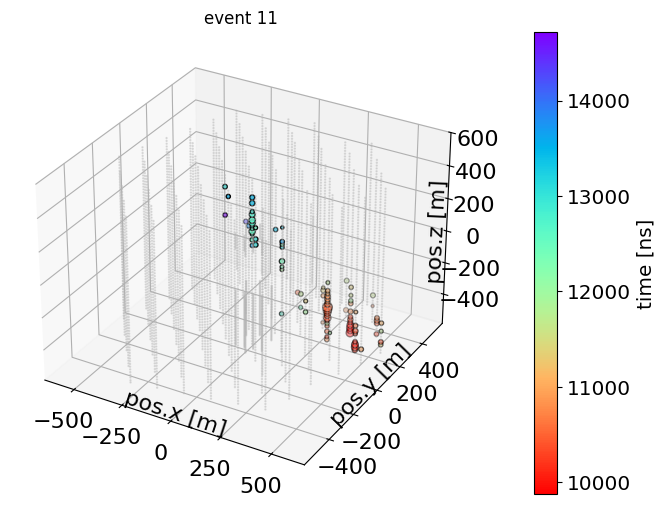

In [5]:
# Plot event.
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(projection='3d')
ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)
ax.set_title(f'event {event_id}')

df = event_data
idx = df['charge'] > 0
geo = sim_handler.geo

im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
im = ax.scatter(df[idx]['x'], df[idx]['y'], df[idx]['z'], s=np.sqrt(df[idx]['charge']*100), c=df[idx]['time'],
                            cmap='rainbow_r',  edgecolors='k', zorder=1000)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
cb = plt.colorbar(im, orientation="vertical", pad=0.1)
cb.set_label(label='time [ns]', size='x-large')
cb.ax.tick_params(labelsize='x-large')

In [6]:
np.sort(event_data['z'].values)

array([-505.68, -499.95, -488.66, -486.34, -482.93, -480.97, -471.64,
       -469.32, -465.91, -465.76, -459.12, -457.23, -454.62, -448.89,
       -442.1 , -437.6 , -435.28, -420.58, -416.34, -412.89, -403.56,
       -401.23, -397.83, -395.96, -395.87, -384.21, -380.8 , -378.84,
       -374.01, -369.51, -367.19, -350.17, -346.76, -333.15, -332.28,
       -332.18, -327.87, -322.95, -318.45, -316.13, -314.26, -301.43,
       -299.11, -295.55, -282.09, -270.  , -267.39, -265.07, -261.84,
       -261.66, -261.51, -248.05, -247.08, -244.49, -240.49, -231.03,
       -216.33, -214.01, -196.98, -179.96, -172.4 , -128.9 ,   10.49,
         27.51,   61.56,   75.02,  109.5 ,  138.38,  143.54,  144.23,
        146.66,  163.68,  177.58,  180.7 ,  194.6 ,  204.3 ,  211.62,
        228.64,  238.34,  245.66,  262.68,  264.41,  265.8 ,  296.73,
        306.43,  313.75,  364.81,  398.85,  434.62,  463.21])

In [7]:
zenith_rec=2.612
azimuth_rec=0.617
# delta_l = 1228.8809003308565

In [11]:
zenith = meta['muon_zenith']
azimuth = meta['muon_azimuth']

In [12]:
print(zenith, azimuth)

2.6120432756599214 0.6149986246084822


In [13]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [14]:
GreatCircleDistance(azimuth, zenith, azimuth_rec, zenith_rec)

0.0010119467588692343

In [15]:
np.rad2deg(0.0010119467588692343)

0.05798027837514993